<h1>A. Data Collection & Exploration

<h2>Import libraries

In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
%matplotlib inline
import sklearn
import xgboost as xgb
import math
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder
from pylift import TransformedOutcome
from pylift.generate_data import dgp
from pylift.eval import UpliftEval
from sklearn.cluster import KMeans
from statistics import mean
import sklearn.metrics
import scikitplot as skplt
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, multilabel_confusion_matrix, confusion_matrix
from imblearn.over_sampling import SMOTE

<h2>Import dataset

In [2]:
df_data = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
df_data.index.name = "id"
df_model = df_data.copy()

<h2>Data exploratioin

In [3]:
pd.options.display.max_columns=100
df_model

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3


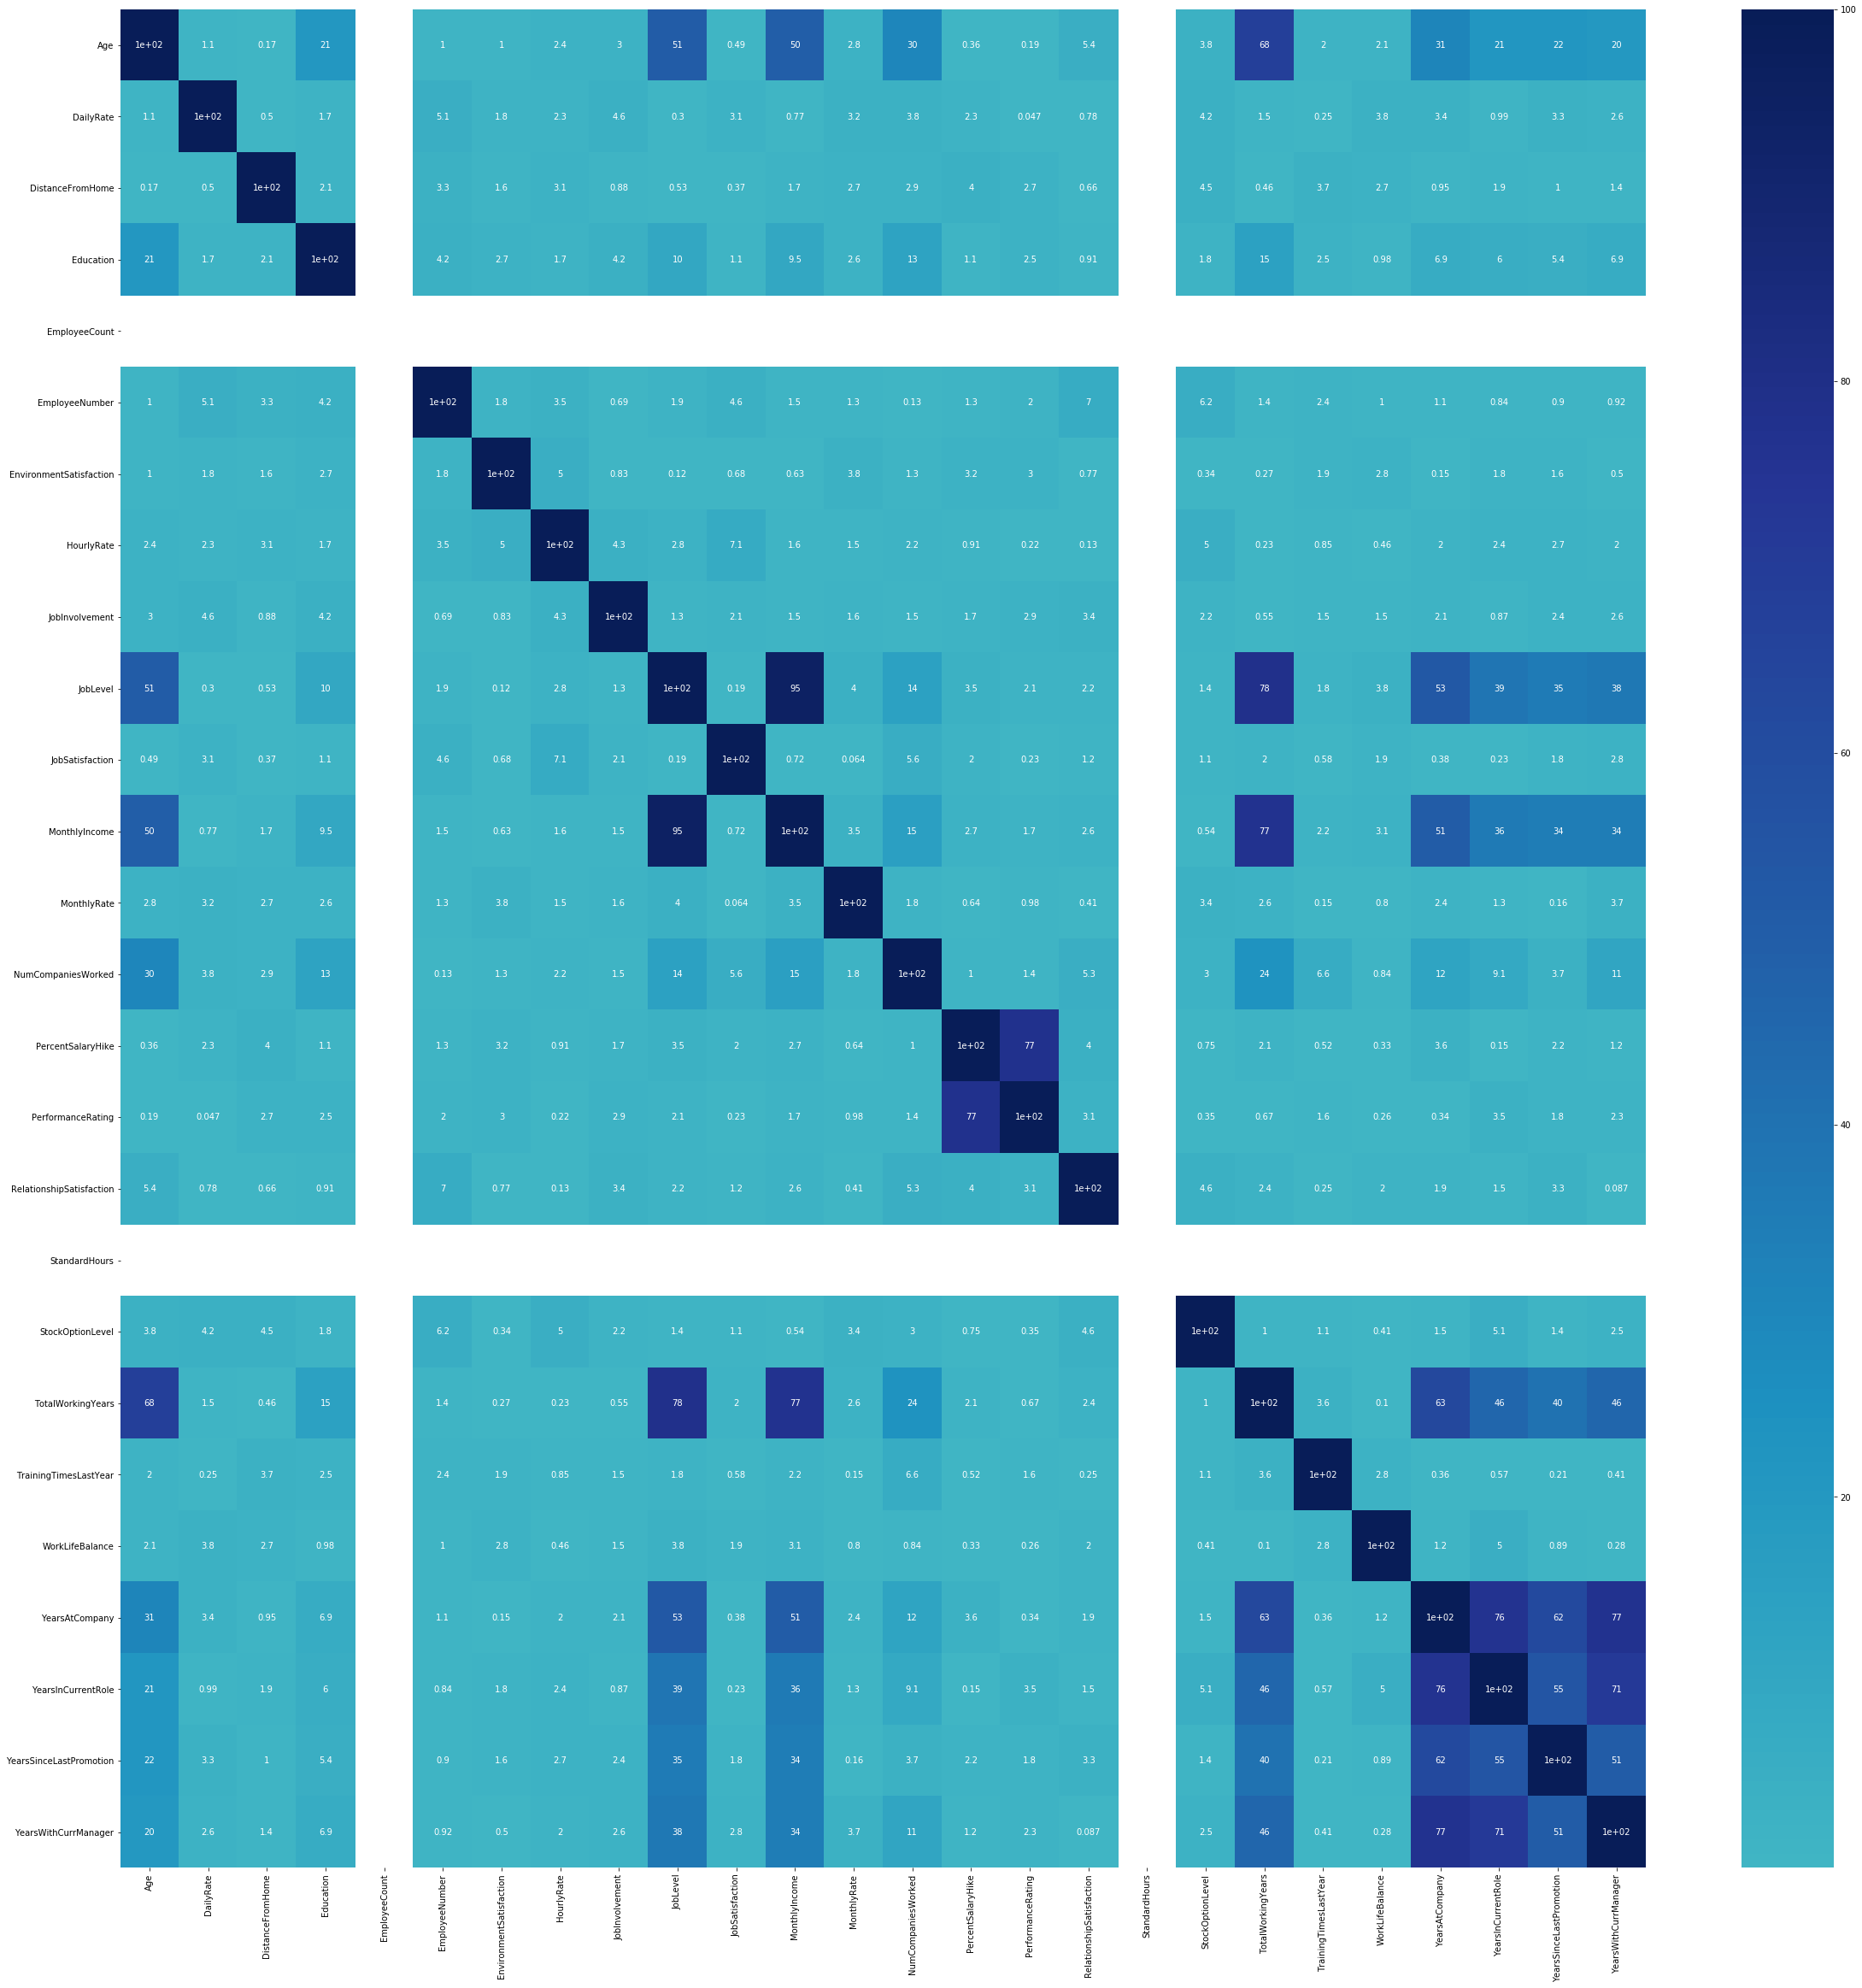

In [4]:
#measure the correlation of Employees who stay
pd.options.display.max_rows=100
corr_matrix = df_model.corr(method ='pearson').abs()*100
# correlation = correlation.drop(labels=['Stay', 'target_class']).sort_values() * 100
plt.figure(figsize=(40,40))
corr = pd.DataFrame(corr_matrix)
sns.heatmap(corr, annot=True, center=0, cmap="YlGnBu")

<h2>Define Cols

In [5]:
#choose the single dependent variable (Positive Outcome)
treat = 'OverTime'

In [6]:
#choose the treatment variable
target = "Attrition"

In [7]:
#checking null
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

<h2>Check N-uniques for non-categorical data

In [8]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype != "object"]
numbers = [[obj,df_data[obj].nunique()] for obj in object_cols]
numbers_data = pd.DataFrame(numbers, columns = ['column', 'N-unique']) 

In [9]:
numbers_data.sort_values(by='N-unique',ascending=False)

,column,N-unique
5,EmployeeNumber,1470
12,MonthlyRate,1427
11,MonthlyIncome,1349
1,DailyRate,886
7,HourlyRate,71
0,Age,43
19,TotalWorkingYears,40
22,YearsAtCompany,37
2,DistanceFromHome,29
23,YearsInCurrentRole,19


<h2>Define Columns to Cluster</h2>
Define column to cluster with high amount of N-Uniques

In [10]:
#choose a column with hiearchy to be label encoded
cluster_cols=['MonthlyRate','MonthlyIncome','DailyRate','HourlyRate','Age']

<h2>Check uniques for categorical data

In [11]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype == "object"]
for obj in object_cols:
    print('\n', obj)
    for unique in df_data[obj].unique():
        print("{} {}".format(unique,sum(df_data[obj] == unique)))


 Attrition
Yes 237
No 1233

 BusinessTravel
Travel_Rarely 1043
Travel_Frequently 277
Non-Travel 150

 Department
Sales 446
Research & Development 961
Human Resources 63

 EducationField
Life Sciences 606
Other 82
Medical 464
Marketing 159
Technical Degree 132
Human Resources 27

 Gender
Female 588
Male 882

 JobRole
Sales Executive 326
Research Scientist 292
Laboratory Technician 259
Manufacturing Director 145
Healthcare Representative 131
Manager 102
Sales Representative 83
Research Director 80
Human Resources 52

 MaritalStatus
Single 470
Married 673
Divorced 327

 Over18
Y 1470

 OverTime
Yes 416
No 1054


<h2>Replace Yes or No to 1 or 0

In [12]:
df_model.Attrition.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)
df_model.OverTime.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)

<h2>Rename Inverted Data

In [13]:
df_model = df_model.rename(columns={"Attrition": "Stay"})
df_model = df_model.rename(columns={"OverTime": "NotOvertime"})
treat = 'NotOvertime'
df_model.head()

,Age,Stay,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,NotOvertime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,41,0,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,0,11,3,1,80,0,8,0,1,6,4,0,5
1,49,1,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,1,23,4,4,80,1,10,3,3,10,7,1,7
2,37,0,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,0,15,3,2,80,0,7,3,3,0,0,0,0
3,33,1,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,0,11,3,3,80,0,8,3,3,8,7,3,0
4,27,1,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,1,12,3,4,80,1,6,3,3,2,2,2,2


<h2>Define columns to Label encode

In [14]:
#choose a column with wide range to be clusterred
label_cols = ['BusinessTravel', 'Gender']

In [15]:
df_data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3


In [16]:
desc = pd.DataFrame()
desc['total N'] = [len(df_model)]
desc['total T'] = [sum(df_model[treat]==1)]
desc['total C'] = [sum(df_model[treat]==0)]
desc['total CR'] = [sum(df_model[treat]==0)&sum(df_model['Stay']==1)]
desc['total CN'] = [sum(df_model[treat]==0)&sum(df_model['Stay']==0)]
desc['total TR'] = [sum(df_model[treat]==1)&sum(df_model['Stay']==1)]
desc['total TN'] = [sum(df_model[treat]==1)&sum(df_model['Stay']==0)]
desc

,total N,total T,total C,total CR,total CN,total TR,total TN
0,1470,1054,416,128,160,1040,12


<h1>B. Data Preprocessing

<h2>Label encoding hierarchy columns

In [17]:
#Label encoding
print("label encoding columns:",label_cols)
label_encoder = LabelEncoder()
for col in label_cols:
    df_model[col] = label_encoder.fit_transform(df_data[col])
    df_model[col] = label_encoder.transform(df_data[col])
print(">>label encoding finished")
df_model[label_cols].head()

label encoding columns: ['BusinessTravel', 'Gender']
>>label encoding finished


,BusinessTravel,Gender
id,,
0,2,0
1,1,1
2,2,1
3,1,0
4,2,1


<h2>Data cleaning

In [18]:
df_model

,Age,Stay,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,NotOvertime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,41,0,2,1102,Sales,1,2,Life Sciences,1,1,2,0,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,0,11,3,1,80,0,8,0,1,6,4,0,5
1,49,1,1,279,Research & Development,8,1,Life Sciences,1,2,3,1,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,1,23,4,4,80,1,10,3,3,10,7,1,7
2,37,0,2,1373,Research & Development,2,2,Other,1,4,4,1,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,0,15,3,2,80,0,7,3,3,0,0,0,0
3,33,1,1,1392,Research & Development,3,4,Life Sciences,1,5,4,0,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,0,11,3,3,80,0,8,3,3,8,7,3,0
4,27,1,2,591,Research & Development,2,1,Medical,1,7,1,1,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,1,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,1,1,884,Research & Development,23,2,Medical,1,2061,3,1,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,1,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,1,2,613,Research & Development,6,1,Medical,1,2062,4,1,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,1,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,1,2,155,Research & Development,4,3,Life Sciences,1,2064,2,1,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,0,20,4,2,80,1,6,0,3,6,2,0,3


In [19]:
#remove unused columns
###
#DROP unused rows
df_model = df_model.drop(['Over18','StandardHours','EmployeeCount','EmployeeNumber', 'PercentSalaryHike'],axis=1)

<h2>One Hot Encoding

In [20]:
#one hot encoding the rest columns
dummies = pd.get_dummies(df_model)
print("\nOne Hot Encoding:",dummies.columns.values)
df_model = dummies
print('>>One Hot Encoding succeeded!')


One Hot Encoding: ['Age' 'Stay' 'BusinessTravel' 'DailyRate' 'DistanceFromHome' 'Education'
 'EnvironmentSatisfaction' 'Gender' 'HourlyRate' 'JobInvolvement'
 'JobLevel' 'JobSatisfaction' 'MonthlyIncome' 'MonthlyRate'
 'NumCompaniesWorked' 'NotOvertime' 'PerformanceRating'
 'RelationshipSatisfaction' 'StockOptionLevel' 'TotalWorkingYears'
 'TrainingTimesLastYear' 'WorkLifeBalance' 'YearsAtCompany'
 'YearsInCurrentRole' 'YearsSinceLastPromotion' 'YearsWithCurrManager'
 'Department_Human Resources' 'Department_Research & Development'
 'Department_Sales' 'EducationField_Human Resources'
 'EducationField_Life Sciences' 'EducationField_Marketing'
 'EducationField_Medical' 'EducationField_Other'
 'EducationField_Technical Degree' 'JobRole_Healthcare Representative'
 'JobRole_Human Resources' 'JobRole_Laboratory Technician'
 'JobRole_Manager' 'JobRole_Manufacturing Director'
 'JobRole_Research Director' 'JobRole_Research Scientist'
 'JobRole_Sales Executive' 'JobRole_Sales Representative'
 '

In [21]:
df_model

,Age,Stay,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,NotOvertime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,41,0,2,1102,1,2,2,0,94,3,2,4,5993,19479,8,0,3,1,0,8,0,1,6,4,0,5,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,49,1,1,279,8,1,3,1,61,2,2,2,5130,24907,1,1,4,4,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,37,0,2,1373,2,2,4,1,92,2,1,3,2090,2396,6,0,3,2,0,7,3,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,33,1,1,1392,3,4,4,0,56,3,1,3,2909,23159,1,0,3,3,0,8,3,3,8,7,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,27,1,2,591,2,1,1,1,40,3,1,2,3468,16632,9,1,3,4,1,6,3,3,2,2,2,2,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,1,1,884,23,2,3,1,41,4,2,4,2571,12290,4,1,3,3,1,17,3,3,5,2,0,3,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1466,39,1,2,613,6,1,4,1,42,2,3,1,9991,21457,4,1,3,1,1,9,5,3,7,7,1,7,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1467,27,1,2,155,4,3,2,1,87,4,2,2,6142,5174,1,0,4,2,1,6,0,3,6,2,0,3,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


<h2>Categorizing target class

Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)
>>Categorizing successfull!


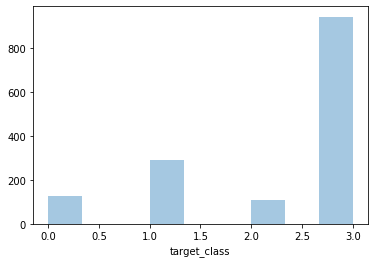

In [22]:
print("Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)")
#to get the CN employees we can simply set the basic value of all data in column target_class equal to 0 
df_model['target_class'] = 0 #CN

#after that we set CR employees with target_class equal to 1 
df_model.loc[(df_model[treat] == 0) & (df_model.Stay > 0),'target_class'] = 1 #CR

#after that we set TN employees with with target_class equal to 2
df_model.loc[(df_model[treat] == 1) & (df_model.Stay == 0),'target_class'] = 2 #TN

#after that we set TR employees with with target_class equal to 3
df_model.loc[(df_model[treat] == 1) & (df_model.Stay > 0),'target_class'] = 3 #TR

print(">>Categorizing successfull!")
sns.distplot(a=df_model.target_class, kde=False)

<h2>Treatment Identification

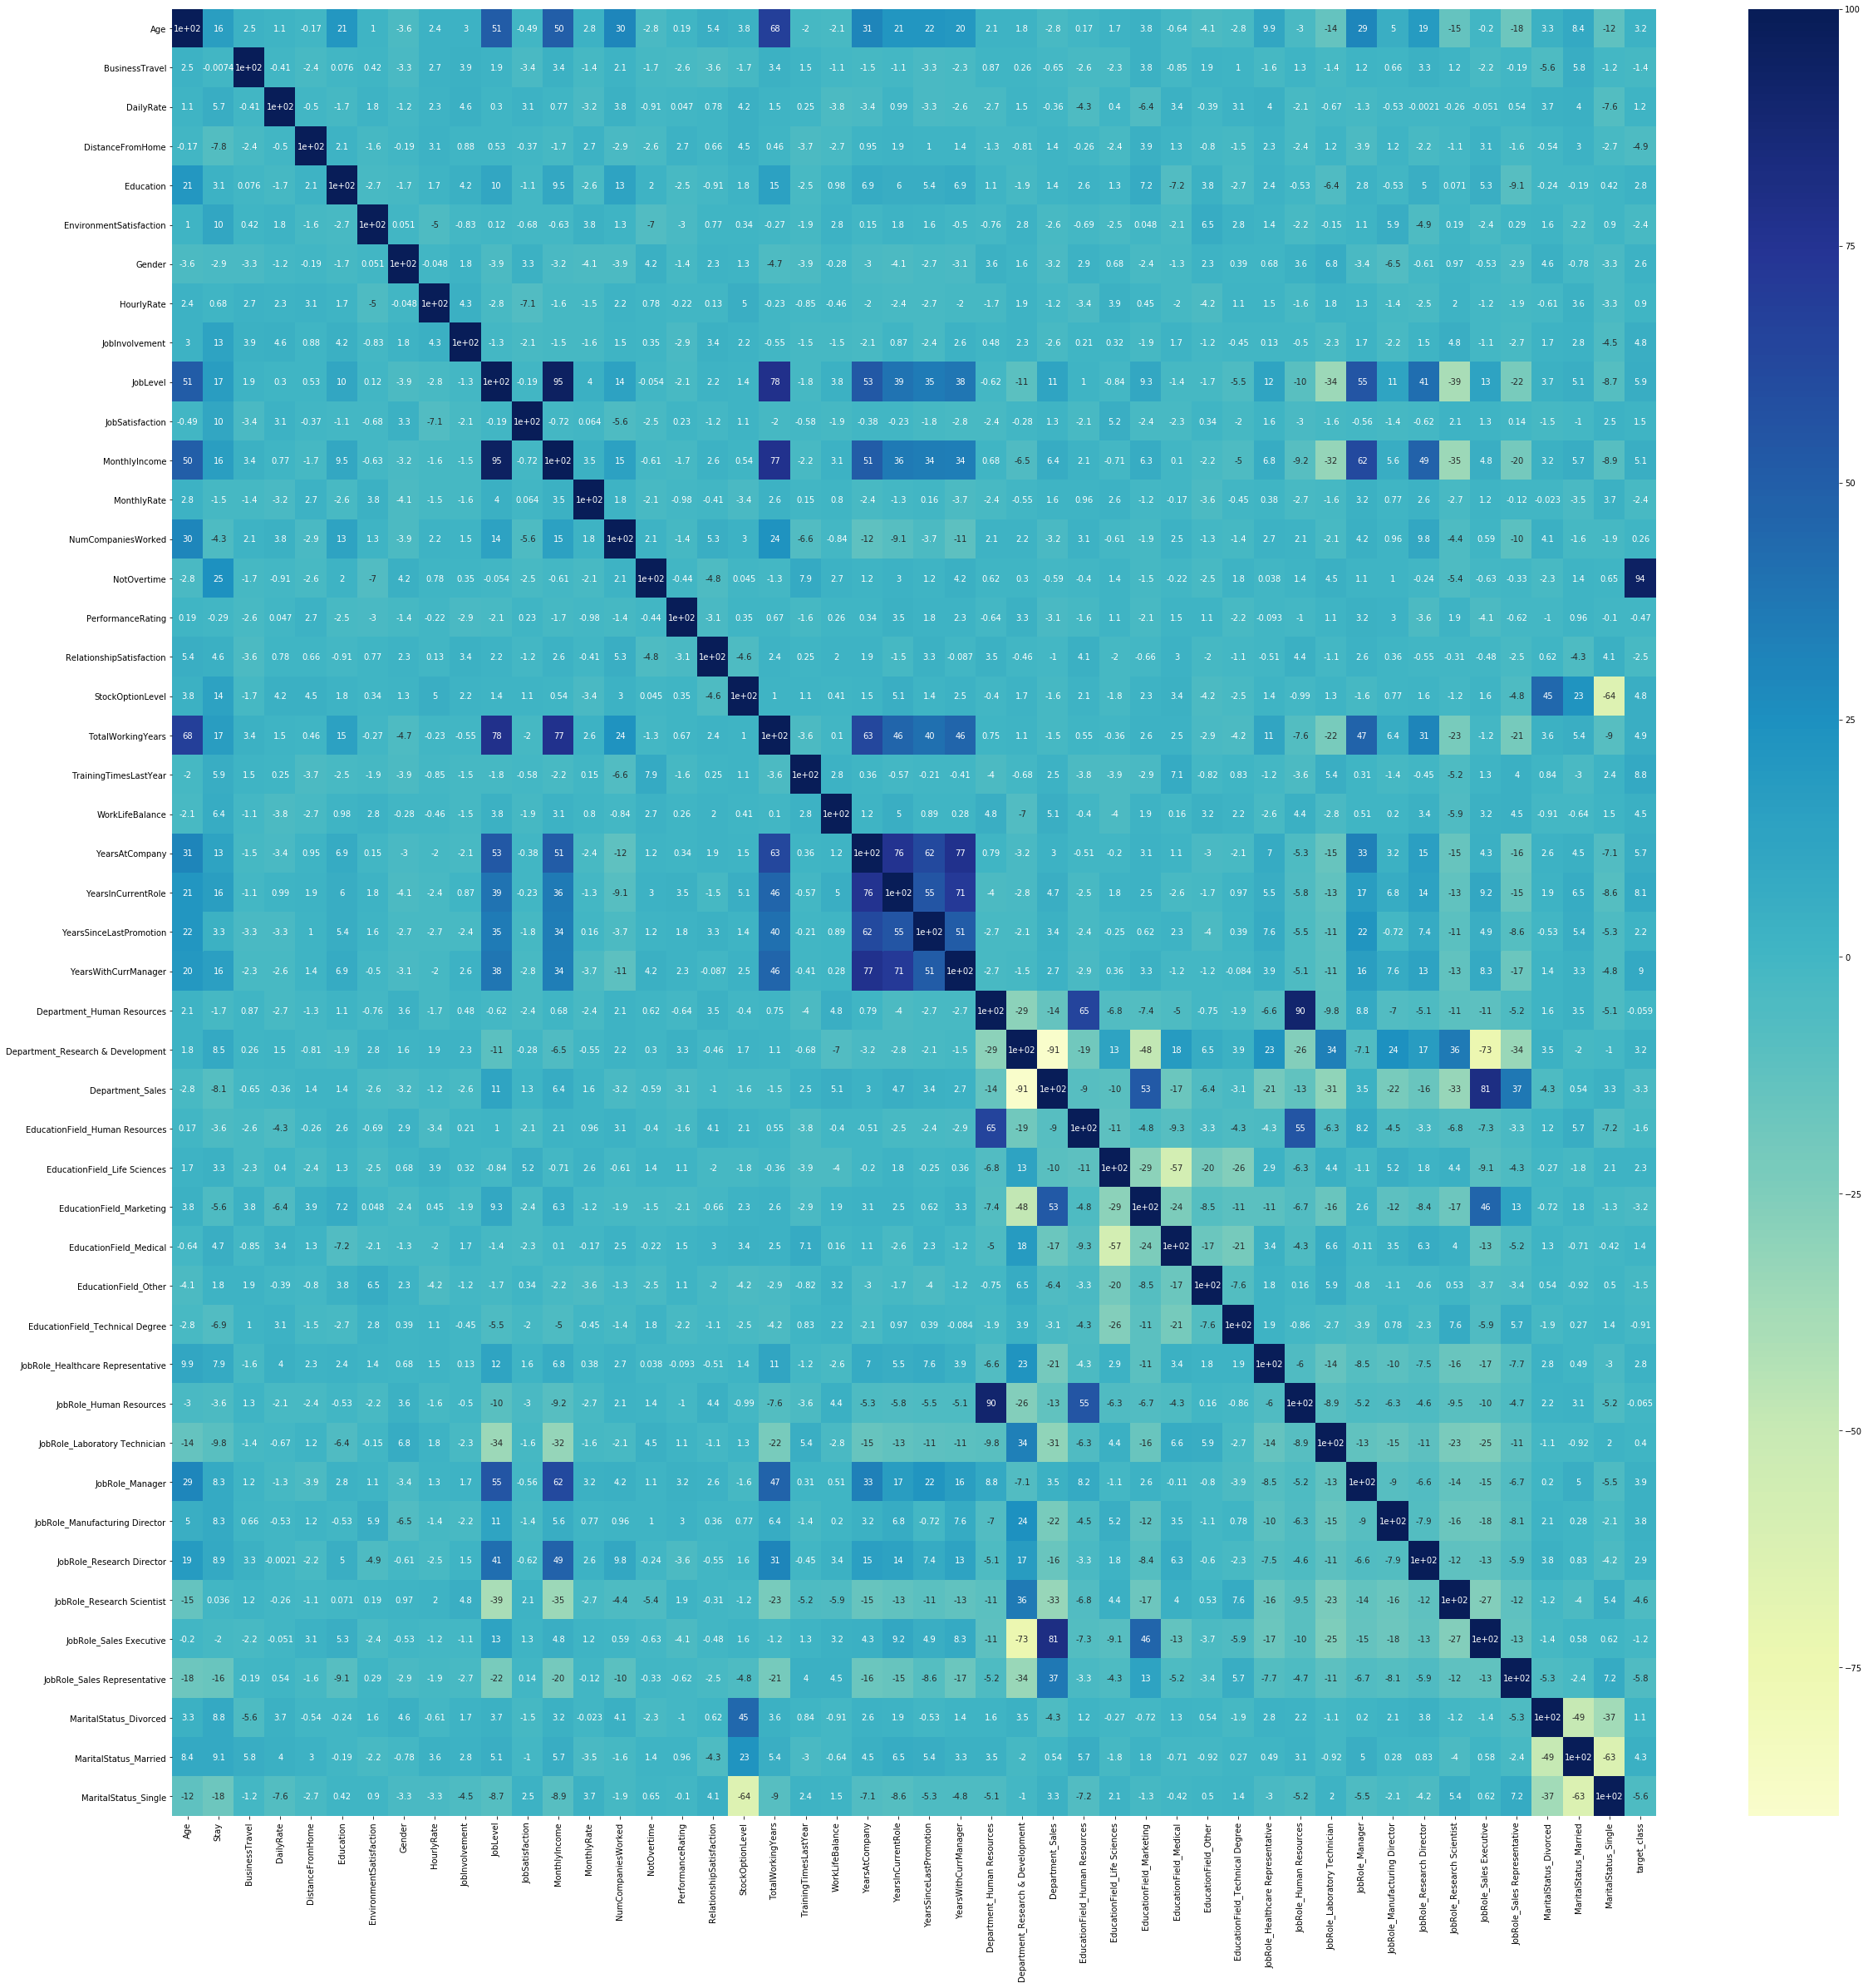

In [23]:
#measure the correlation of Employees who stay
treatment_corr_matrix = df_model.corr(method ='pearson')
#plot the data
plt.figure(figsize=(40,40))
corr = pd.DataFrame(treatment_corr_matrix.drop(labels=['Stay', 'target_class'])* 100)
sns.heatmap(corr, annot=True, center=0, cmap="YlGnBu")

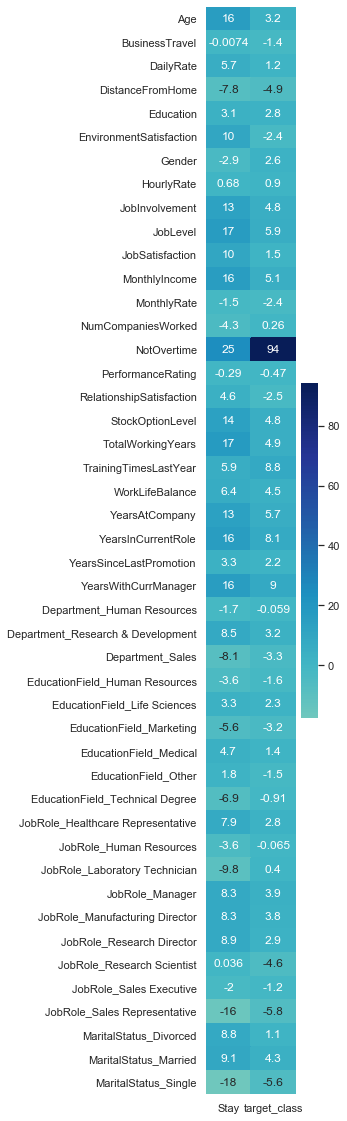

In [24]:
treatment_corr_table = pd.DataFrame(treatment_corr_matrix['Stay'].drop(labels=['Stay', 'target_class']))
treatment_corr_table['target_class'] = pd.DataFrame(treatment_corr_matrix['target_class'].drop(labels=['Stay', 'target_class']))
#plot features that correlated with stay and target class
plt.figure(figsize=(2,20))
sns.set(font_scale = 1)
sns.heatmap(treatment_corr_table*100, annot=True, center=0, cmap="YlGnBu")

Text(0.5, 1, 'Top 5 Correlation')

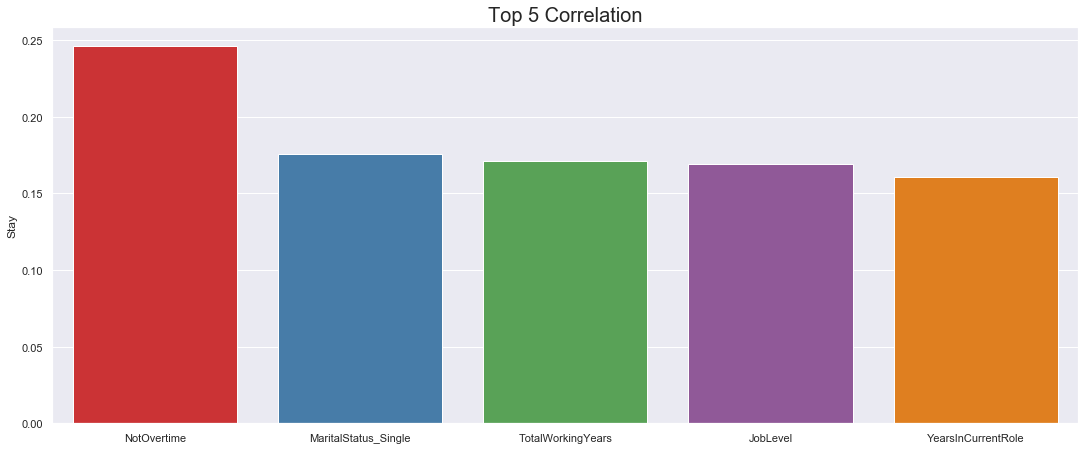

In [25]:
#define what column to drop
treat_matrix = treatment_corr_table.copy()
treat_matrix = treat_matrix.abs()*100 < 0
treat_matrix['and'] = treat_matrix.all(axis = 1)
target_labels = [treat, 'target_class','Stay']
#define what column to drop
drop_both = treat_matrix.index[treat_matrix['and'] == True].tolist()
drop_both.extend(target_labels)
drop_uplift = treat_matrix.index[treat_matrix['target_class'] == True].tolist()
drop_uplift.extend(target_labels)
drop_stay = treat_matrix.index[treat_matrix['Stay'] == True].tolist()
drop_stay.extend(target_labels)
# find the largest corr and plot it
largest_corr = treatment_corr_table.Stay.abs().nlargest(5)
largest = sns.barplot(y=largest_corr,x=largest_corr.index, palette='Set1')
plt.subplots_adjust(right=2.5)
plt.subplots_adjust(top=1.5)
plt.title('Top 5 Correlation',y=1, fontsize=20)

In [26]:
pd.DataFrame(largest_corr.round(2))

,Stay
NotOvertime,0.25
MaritalStatus_Single,0.18
TotalWorkingYears,0.17
JobLevel,0.17
YearsInCurrentRole,0.16


In [27]:
round(treatment_corr_table*100,2)

,Stay,target_class
Age,15.92,3.16
BusinessTravel,-0.01,-1.42
DailyRate,5.67,1.20
DistanceFromHome,-7.79,-4.90
Education,3.14,2.83
EnvironmentSatisfaction,10.34,-2.39
Gender,-2.95,2.56
HourlyRate,0.68,0.90
JobInvolvement,13.00,4.84
JobLevel,16.91,5.86


In [28]:
treat_matrix = treatment_corr_table.copy()
treat_matrix = treat_matrix.abs()*100 < 0
treat_matrix['and'] = treat_matrix.all(axis = 1)
target_labels = [treat, 'target_class','Stay']
drop_both = treat_matrix.index[treat_matrix['and'] == True].tolist()
drop_both.extend(target_labels)
drop_uplift = treat_matrix.index[treat_matrix['target_class'] == True].tolist()
drop_uplift.extend(target_labels)
drop_stay = treat_matrix.index[treat_matrix['Stay'] == True].tolist()
drop_stay.extend(target_labels)

AxesSubplot(0.125,0.125;2.375x1.375)


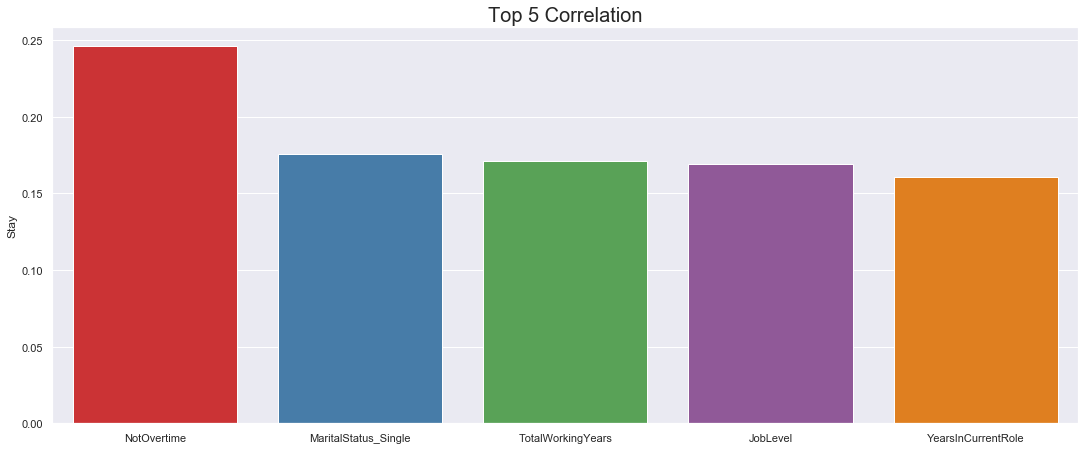

In [29]:
largest_corr = treatment_corr_table.Stay.abs().nlargest(5)
largest = sns.barplot(y=largest_corr,x=largest_corr.index, palette='Set1')
# chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='left')
plt.subplots_adjust(right=2.5)
plt.subplots_adjust(top=1.5)
plt.title('Top 5 Correlation',y=1, fontsize=20)
print(largest)

In [30]:
pd.DataFrame(largest_corr.round(2))

,Stay
NotOvertime,0.25
MaritalStatus_Single,0.18
TotalWorkingYears,0.17
JobLevel,0.17
YearsInCurrentRole,0.16


<h1><i>MODELING

<h3> Set Labels

In [31]:
#create features
X = df_model
#create labels for churn target
y_stay = df_model.Stay
#create labels for treatment
t = df_model[treat]
#create labels
y_target_class = df_model.target_class

In [32]:
#splitting train and test groups
X_train, X_test, y_train, y_test, z_train, z_test  = train_test_split(X, y_stay, y_target_class, test_size=0.3, random_state=42, stratify = t)

<h2>Churn Prediction

In [33]:
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model_stay = xgb.XGBClassifier().fit(X_train.drop(drop_stay,axis=1), y_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict_stay = xgb_model_stay.predict(X_test.drop(drop_stay,axis=1))
overall_proba_stay = xgb_model_stay.predict_proba(X_test.drop(drop_stay,axis=1))
# put result in dataframe
df_data_churn_all = X_test.copy()
df_data_churn_all['p_stay'] = overall_predict_stay
df_data_churn_all['stay_score'] = overall_proba_stay[:,0]

In [34]:
# evaluate predictions
accuracy = accuracy_score(y_test, overall_predict_stay)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.07%


In [35]:
confusion = confusion_matrix(y_test, overall_predict_stay)
tn, fp, fn, tp = confusion.ravel()
confusion = pd.DataFrame(confusion, columns = ['True','False'], index = ['Negative','Positive'])
confusion

,True,False
Negative,9,54
Positive,3,375


In [36]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, overall_predict_stay)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, overall_predict_stay)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, overall_predict_stay)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, overall_predict_stay)
print('F1 score: %f' % f1)

Accuracy: 0.870748
Precision: 0.874126
Recall: 0.992063
F1 score: 0.929368


<h2>Uplift Modeling - Generalized 4 Quadrant 

In [37]:
# from sklearn import preprocessing
# y_target_class = preprocessing.label_binarize(y_target_class, classes=[0, 1, 2, 3])

In [38]:
# def timer(start_time=None):
#     if not start_time:
#         start_time = datetime.now()
#         return start_time
#     elif start_time:
#         thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
#         tmin, tsec = divmod(temp_sec, 60)
#         print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
# # A parameter grid for XGBoost
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

In [39]:
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model_target_class = xgb.XGBClassifier()
xgb_model_target_class = xgb_model_target_class.fit(X_train.drop(drop_uplift,axis=1), z_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict_target_class = xgb_model_target_class.predict(X_test.drop(drop_uplift,axis=1))
overall_proba_target_class=xgb_model_target_class.predict_proba(X_test.drop(drop_uplift,axis=1))

# insert predicted target to uplift dataframe
df_data_uplift_all = X_test.copy()
df_data_uplift_all['p_target'] = overall_predict_target_class

# assign probabilities to 4 different columns
df_data_uplift_all['proba_CN'] = overall_proba_target_class[:,0] 
df_data_uplift_all['proba_CR'] = overall_proba_target_class[:,1] 
df_data_uplift_all['proba_TN'] = overall_proba_target_class[:,2] 
df_data_uplift_all['proba_TR'] = overall_proba_target_class[:,3]

#calculate uplift score for all customers
df_data_uplift_all['uplift_score'] = df_data_uplift_all.eval('proba_CN/(proba_CN+proba_CR) + proba_TR/(proba_TN+proba_TR) - proba_TN/(proba_TN+proba_TR) - proba_CR/(proba_CN+proba_CR)')

In [40]:
# evaluate predictions
accuracy = accuracy_score(z_test, overall_predict_target_class)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 61.68%


In [41]:
uplift_confusion = multilabel_confusion_matrix(y_test, overall_predict_target_class)

In [42]:
uplift_confusion

array([[[375,   3],
        [ 59,   4]],

       [[ 59,   4],
        [370,   8]],

       [[438,   3],
        [  0,   0]],

       [[ 22, 419],
        [  0,   0]]], dtype=int64)

In [43]:
uplift_confusion0 = pd.DataFrame(uplift_confusion[0], columns = ['True','False'], index = ['Positive','Negative'])
uplift_confusion1 = pd.DataFrame(uplift_confusion[1], columns = ['True','False'], index = ['Positive','Negative'])
uplift_confusion2 = pd.DataFrame(uplift_confusion[2], columns = ['True','False'], index = ['Positive','Negative'])
uplift_confusion3 = pd.DataFrame(uplift_confusion[3], columns = ['True','False'], index = ['Positive','Negative'])

<h2>Uplift Modeling - Traditional Approach

In [44]:
# #put response label, if target class = 3, response = 1, else response = 0
# response_index = df_model.index[(df_model.target_class == 3)==True]
# df_model_response = df_model.copy()
# df_model_response['response'] = 0
# df_model_response['response'].iloc[response_index]=1

In [45]:
# y_response = df_model_response['response']

In [46]:
# xgb_hyper = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
#                     silent=True, nthread=1)
# # META CODE
# from sklearn.multiclass import OneVsRestClassifier
# from xgboost import XGBClassifier
# from sklearn.preprocessing import MultiLabelBinarizer

# clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1, max_depth=4))

# # You may need to use MultiLabelBinarizer to encode your variables from arrays [[x, y, z]] to a multilabel 
# # format before training.
# # mlb = MultiLabelBinarizer()
# # y_response = mlb.fit_transform(y_response)

# clf.fit(X, y_response)
# # clf_SVM = OneVsRestClassifier(xgb.XGBClassifier(n_jobs=-1, max_depth=4))
# # params = {
# #       'estimator__C': [0.5, 1.0, 1.5],
# #       'estimator__tol': [1e-3, 1e-4, 1e-5],
# #       }
# # gs = GridSearchCV(clf_SVM, params, cv=5, scoring='roc_auc')
# # gs.fit(X, y_target_class)

In [47]:
# #create feature set and labels
# xgb_model_traditional = xgb.XGBClassifier(objective='binary:logistic').fit(X_train.drop(drop_uplift,axis=1), y_train)
# #Calculate probabilities for all customers using eXtreme Gradient Boost
# overall_predict_traditional = xgb_model_traditional.predict(X_test.drop(drop_uplift,axis=1))
# overall_proba_traditional = xgb_model_traditional.predict_proba(X_test.drop(drop_uplift,axis=1))
# # insert predicted target to uplift dataframe
# df_data_traditional = X_test
# # put result in dataframe
# df_data_traditional['p_response'] = overall_predict_traditional
# df_data_traditional['response_score'] = overall_proba_traditional[:,1]


In [48]:
# # evaluate predictions
# accuracy = accuracy_score(y_test, overall_predict_traditional)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

<h2> creating data for Ranking and Evaluation

In [49]:
df_data_churn_all = df_data_churn_all[['Stay', treat, 'target_class', 'p_stay', 'stay_score']]
df_data_uplift_all = df_data_uplift_all[['Stay', treat, 'target_class', 'p_target', 'uplift_score']]

<h2>Rank data for Churn prediction

In [50]:
#both treatment and control
print("Ranking data for Churn Prediction with control included")

df_data_churn_all = df_data_churn_all.sort_values(by ='stay_score',ascending=True)
df_data_churn_all = df_data_churn_all.reset_index()

# #treatment only
# df_data_churn_all = df_data_churn_all[df_data_churn_all.target_class > 1]
# print("Ranking data for Churn Prediction with control not included")
# df_data_churn_all = df_data_churn_all.sort_values(by ='stay_score',ascending=True)
# df_data_churn_all = df_data_churn_all.reset_index()

Ranking data for Churn Prediction with control included


<h2>Rank data for Uplift prediction

In [51]:
#both treatment and control
print("Ranking data for Churn Uplift with control included")
df_data_uplift_all.sort_values(by ='uplift_score',ascending=False, inplace=True)
df_data_uplift_all.reset_index(inplace=True, drop=True)

# #choose treatment only
# df_data_uplift_all = df_data_uplift_all[df_data_uplift_all.target_class > 1]
# print("Ranking data for Churn Uplift with control not included")
# df_data_uplift_all = df_data_uplift_all.sort_values(by ='uplift_score',ascending=False)
# df_data_uplift_all = df_data_uplift_all.reset_index()

Ranking data for Churn Uplift with control included


In [52]:
# *checking bug
print(sum(df_data_churn_all.target_class[0:-1]==0))
print(sum(df_data_uplift_all.target_class[0:-1]==0))

29
28


In [53]:
df_data_uplift_all

,Stay,NotOvertime,target_class,p_target,uplift_score
0,0,0,0,3,1.548340
1,0,1,2,3,1.524210
2,1,1,3,3,1.478591
3,1,0,1,3,1.477042
4,1,1,3,3,1.465355
...,...,...,...,...,...
436,1,1,3,3,-0.234279
437,1,1,3,1,-0.236441
438,0,1,2,2,-0.315320
439,1,1,3,1,-0.327489


<h2>Rank data for Traditional Approach

In [54]:
# #both treatment and control
# print("Ranking data for Churn Uplift with control included")
# df_data_Traditional_all = df_data_traditional.copy()
# df_data_Traditional_all = df_data_Traditional_all.sort_values(by ='response_score',ascending=False)
# df_data_Traditional_all = df_data_Traditional_all.reset_index()

# #choose treatment only
# df_data_Traditional = df_data_traditional[df_data_traditional.target_class > 1]
# print("Ranking data for Churn Uplift with control not included")
# df_data_Traditional = df_data_Traditional.sort_values(by ='response_score',ascending=False)
# df_data_Traditional = df_data_Traditional.reset_index()

In [55]:
sns.set_style("whitegrid")

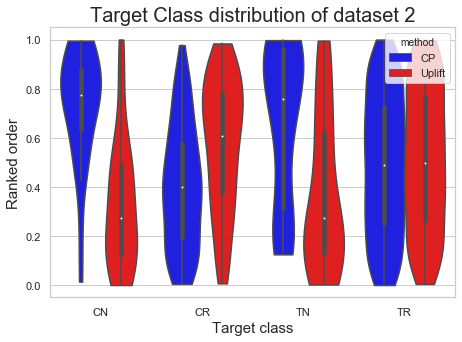

In [56]:
#churn prediction method
churn_target_class = df_data_churn_all.copy()
churn_target_class = churn_target_class.reset_index()
churn_target_class.target_class.replace([0, 1, 2, 3], ['CN', 'CR', 'TN', 'TR'], inplace = True)
churn_target_class['method'] = 'CP'
#uplift method
uplift_target_class = df_data_uplift_all.copy()
uplift_target_class = uplift_target_class.reset_index()
uplift_target_class.target_class.replace([0, 1, 2, 3], ['CN', 'CR', 'TN', 'TR'], inplace = True)
uplift_target_class['method'] = 'Uplift'
#combine both method
all_method_target_class = pd.concat([churn_target_class, uplift_target_class])
max_index = max(all_method_target_class['index'])
all_method_target_class['index'] = all_method_target_class['index']/max_index
plt.figure(figsize=(15,10))
sns.violinplot(data=all_method_target_class, x='target_class', y='index', hue='method', 
               yticklabels=np.arange(0.1,1.1,0.1), cut=0, palette=['blue','red'],
              order=['CN', 'CR', 'TN', 'TR'])
plt.title('Target Class distribution of dataset 2',fontsize=20)
plt.ylabel('Ranked order',fontsize=15)
plt.xlabel('Target class',fontsize=15)
plt.subplots_adjust(right=0.5)
plt.subplots_adjust(top=0.5)

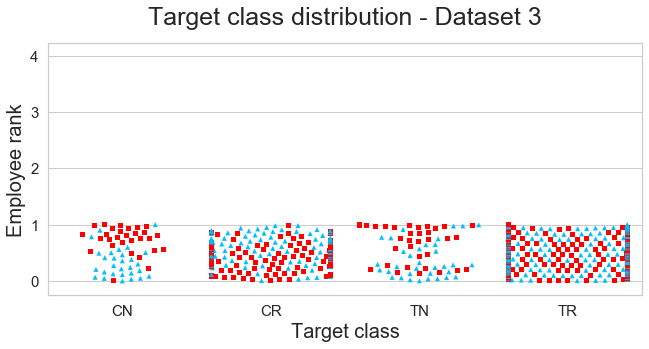

In [57]:
# dummy plots, just to get the Path objects
fig, ax = plt.subplots(1,1)
a = ax.scatter([1,2],[3,4], marker='s')
b = ax.scatter([1,2],[3,4], marker='^')
square_mk, = a.get_paths()
triangle_up_mk, = b.get_paths()
a.remove()
b.remove()


ax = sns.swarmplot(data=all_method_target_class, x='target_class', y='index', 
              hue='method', palette=['red','deepskyblue'], 
                   order=['CN', 'CR', 'TN', 'TR'], size=5, edgecolor = 'black',
                   )
plt.title('Target class distribution - Dataset 3',fontsize=25, y=1.05)
plt.ylabel('Employee rank',fontsize=20)
plt.xlabel('Target class',fontsize=20)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1)

# plt.setp(ax.get_legend().get_texts(), fontsize='15')
ax.tick_params(labelsize=15)

collections = ax.collections
unique_colors = np.unique(collections[0].get_facecolors(), axis=0)
markers = [triangle_up_mk, square_mk]  # this array must be at least as large as the number of unique colors
for collection in collections:
    paths = []
    for current_color in collection.get_facecolors():
        for possible_marker,possible_color in zip(markers, unique_colors):
            if np.array_equal(current_color,possible_color):
                paths.append(possible_marker)
                break
    collection.set_paths(paths)
#update legend
ax.legend_.remove()
# ax.legend(collections[-2:],pd.unique(all_method_target_class.method))  

In [58]:
#store dataset to be used globally
dataset_2 = all_method_target_class
%store dataset_2

Stored 'dataset_2' (DataFrame)


In [59]:
#measure the train data
train_description = pd.Series()
train_description['train_size'] = [len(X_train)]
train_description['train_treatment_response_rate'] = [(round(sum(X_train['target_class'] == 3) /sum(X_train[treat]),4))]
train_description['train_control_response_rate'] = [(round(sum(X_train['target_class'] == 1) /sum(X_train[treat]==0),4))]
#measure the test data
test_description = pd.Series()
test_description['test_size'] = [len(X_test)]
test_description['test_treatment_response_rate'] = [round(sum(X_test['target_class'] == 3) /sum(X_test[treat]),4)]
test_description['test_control_response_rate'] = [round(sum(X_test['target_class'] == 1) /sum(X_test[treat]==0),4)]
#print the result
print(train_description)
print(test_description)

train_size                         [1029]
train_treatment_response_rate     [0.897]
train_control_response_rate      [0.6632]
dtype: object
test_size                          [441]
test_treatment_response_rate    [0.8924]
test_control_response_rate       [0.768]
dtype: object


C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


<h2>EMP

In [60]:
CN, TN, C, T = sum((df_model[treat] == 0)&(df_model['Stay'] == 0)), sum((df_model[treat] == 1)&(df_model['Stay'] == 0)), sum(df_model[treat] == 0), sum(df_model[treat] == 1)
mu_CN = CN/C
mu_CR = 1 - mu_CN
mu_TN = TN/T
mu_TR = 1 - mu_TN

In [61]:
#define basic variable c=cost, j=decile_count
k=11
#set decile step/10 or /100
j=round(len(df_data_churn_all)/10)
#prepare 3 dataframe for CPMP
EMP_C = pd.DataFrame({"n":[], 
                      "emp":[]})
EMP_U = EMP_C.copy()
b=100
#not over work will cost minus profit to the company
i_cost=5
d=0
A=0
m_max = (len(df_data_churn_all)-1)
C_list, U_list = [], []

for i in range(k):
    m=i*j
    
    #alpha:
    
    CN_c = sum(df_data_churn_all.loc[0:m,'target_class']==0)
    CR_c = sum(df_data_churn_all.loc[0:m,'target_class']==1)
    TN_c = sum(df_data_churn_all.loc[0:m,'target_class']==2)
    TR_c = sum(df_data_churn_all.loc[0:m,'target_class']==3)
            
    CN_u = sum(df_data_uplift_all.loc[0:m,'target_class']==0)
    CR_u = sum(df_data_uplift_all.loc[0:m,'target_class']==1)
    TN_u = sum(df_data_uplift_all.loc[0:m,'target_class']==2)
    TR_u = sum(df_data_uplift_all.loc[0:m,'target_class']==3)
            
    CNTN_c= (CN_c*mu_TN) + (TN_c*mu_CN)
    CNTR_c= (CN_c*mu_TR) + (TR_c*mu_CN)
    CRTN_c= (CR_c*mu_TN) + (TN_c*mu_CR)
    CRTR_c= (CR_c*mu_TR) + (TR_c*mu_CR)
    
    CNTN_u= (CN_u*mu_TN) + (TN_u*mu_CN)
    CNTR_u= (CN_u*mu_TR) + (TR_u*mu_CN)
    CRTN_u= (CR_u*mu_TN) + (TN_u*mu_CR)
    CRTR_u= (CR_u*mu_TR) + (TR_u*mu_CR)
    
    #1-alpha:
    CN_c_2 = sum(df_data_churn_all.loc[m+1:m_max,'target_class']==0)
    CR_c_2 = sum(df_data_churn_all.loc[m+1:m_max,'target_class']==1)
    TN_c_2 = sum(df_data_churn_all.loc[m+1:m_max,'target_class']==2)
    TR_c_2 = sum(df_data_churn_all.loc[m+1:m_max,'target_class']==3)
            
    CN_u_2 = sum(df_data_uplift_all.loc[m+1:m_max,'target_class']==0)
    CR_u_2 = sum(df_data_uplift_all.loc[m+1:m_max,'target_class']==1)
    TN_u_2 = sum(df_data_uplift_all.loc[m+1:m_max,'target_class']==2)
    TR_u_2 = sum(df_data_uplift_all.loc[m+1:m_max,'target_class']==3)
            
    CNTR_c_2= (CN_c_2*mu_TR) + (TR_c_2*mu_CN)
    CRTN_c_2= (CR_c_2*mu_TN) + (TN_c_2*mu_CR)
    
    CNTR_u_2= (CN_u_2*mu_TR) + (TR_u_2*mu_CN)
    CRTN_u_2= (CR_u_2*mu_TN) + (TN_u_2*mu_CR)
         
    #churn Estimated  Maximum Profit
    emp_c = (CNTR_c*(b-i_cost-d)+CNTN_c*(-d)+CRTR_c*(-i_cost-d)+CRTN_c*(-b-d)) + (CRTN_c_2*(b)+CNTR_c_2*(-b))
    #Churn Uplift Estimated Maximum Profit
    emp_u = (CNTR_u*(b-i_cost-d)+CNTN_u*(-d)+CRTR_u*(-i_cost-d)+CRTN_u*(-b-d)) + (CRTN_u_2*(b)+CNTR_u_2*(-b))
#     #churn Estimated  Maximum Profit
#     emp_c = (CRTN_c*(b-i_cost-d)+CNTN_c*(-d)+CRTR_c*(-i_cost-d)+CNTR_c*(-b-d)) 
#     #Churn Uplift Estimated Maximum Profit
#     emp_u = (CRTN_u*(b-i_cost-d)+CNTN_u*(-d)+CRTR_u*(-i_cost-d)+CNTR_u*(-b-d))  
    
    
    C_list.append(pd.Series([((i)/10),emp_c], index=EMP_C.columns)) 
    U_list.append(pd.Series([((i)/10),emp_u], index=EMP_U.columns))
    
EMP_C = EMP_C.append(C_list , ignore_index=True)
EMP_U = EMP_U.append(U_list , ignore_index=True)

# add q0 into dataframe
# q0 = pd.DataFrame({'n':0, 'emp':0}, index =[0])
# EMPC = pd.concat([q0, EMP_C]).reset_index(drop = True)
# EMPU = pd.concat([q0, EMP_U]).reset_index(drop = True)

#no q0
EMPC = EMP_C
EMPU = EMP_U

In [62]:
#create new column method = churn_prediction
EMPC['method'] = 'CP'

#create new column method = uplift_modelling Prediction
EMPU['method'] = 'Uplift'

# #Combine both Churn Prediction and uplift modelling result
# result_emp = pd.concat([EMPU, EMPC])
# result_emp = result_emp.sort_values(by='n')
# result_emp

#no q0
#Combine both Churn Prediction and uplift modelling result
result_emp = pd.concat([EMPU, EMPC])
result_emp = result_emp.sort_values(by='n')
result_emp

,n,emp,method
0,0.0,-7667.912349,Uplift
0,0.0,-7786.503613,CP
1,0.1,-6738.278718,Uplift
1,0.1,-6259.687454,CP
2,0.2,-4898.010145,Uplift
2,0.2,-5745.053824,CP
3,0.3,-3936.193986,Uplift
3,0.3,-4916.828930,CP
4,0.4,-1997.334148,Uplift
4,0.4,-3345.786564,CP


In [63]:
#store dataset to be used globally
result_emp_2 = result_emp
%store result_emp_2

Stored 'result_emp_2' (DataFrame)


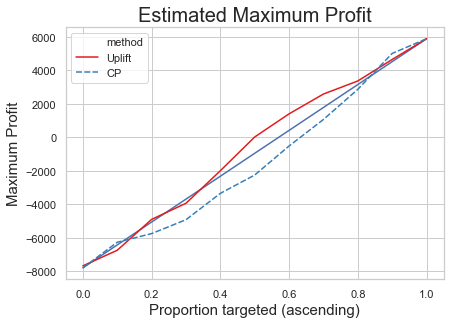

In [64]:
random = np.linspace(EMPC['emp'][0],EMPC['emp'][k-1],k)
sns.lineplot(x=EMPC.n, y=random)
sns.lineplot(x='n', y='emp', hue='method', data=result_emp, style="method", palette='Set1')
sns.set_style("whitegrid")
plt.title('Estimated Maximum Profit',fontsize=20)
plt.xlabel('Proportion targeted (ascending)',fontsize=15)
plt.ylabel('Maximum Profit',fontsize=15)
plt.subplots_adjust(right=1)
plt.subplots_adjust(top=1)

<h2>Treatment and Control

In [65]:
#prepare 3 dataframe for CPMPU
CPMPU = pd.DataFrame({"n":[], 
                      "QINI":[], 
                      "TR":[],  
                      "mpu":[]})
CUMPU, PUMPU = CPMPU.copy(), CPMPU.copy()
CP_list, CU_list, PU_list = [], [], []

#prepare dataframe for QINI Curves
QU = pd.DataFrame({"n":[],  
                    "uplift":[]})
QC = QU.copy()
QP = QU.copy()
QU_list, QC_list, QP_list = [], [], []
p4_1=(b-i_cost)

j = 10
k = math.ceil(len(df_data_churn_all)/j)
for i in range(j):
    m=(i+1)*k 
    
#     #Input total actual control and treatment data
    churn_control_count = sum(df_data_churn_all[treat]==0)
    churn_treatment_count = sum(df_data_churn_all[treat]==1)
#     #Input total actual control and treatment data
    uplift_control_count = sum(df_data_uplift_all[treat]==0)
    uplift_treatment_count = sum(df_data_uplift_all[treat]==1)
    #Actual Qini Churn - Input Data
    RC_churn = sum((df_data_churn_all.Stay[0:m]==1)&(df_data_churn_all[treat][0:m]==0))
    RT_churn = sum((df_data_churn_all.Stay[0:m]==1)&(df_data_churn_all[treat][0:m]==1))
    NC_churn = sum(df_data_churn_all[treat][0:m]==0)
    NT_churn = sum(df_data_churn_all[treat][0:m]==1)
    #Actual Qini Uplift - Input Data
    RC_uplift = sum((df_data_uplift_all.Stay[0:m]==1)&(df_data_uplift_all[treat][0:m]==0))
    RT_uplift = sum((df_data_uplift_all.Stay[0:m]==1)&(df_data_uplift_all[treat][0:m]==1))
    NC_uplift = sum(df_data_uplift_all[treat][0:m]==0)
    NT_uplift = sum(df_data_uplift_all[treat][0:m]==1)
    #Predicted Qini Uplift - Input Data
    RC_predicted = sum(df_data_uplift_all.p_target[0:m]==1)
    RT_predicted = sum(df_data_uplift_all.p_target[0:m]==3)
    NC_predicted = sum(df_data_uplift_all.p_target[0:m]<=1)
    NT_predicted = sum(df_data_uplift_all.p_target[0:m]>=2)
    
#     pilih salah satu metode:    
    QINI_c = ((RT_churn/churn_treatment_count) - (RC_churn/churn_control_count))
    QINI_u = ((RT_uplift/uplift_treatment_count) - (RC_uplift/uplift_control_count))   
    #Calculate QINI
#     QINI_c = (RT_churn-((RC_churn*NT_churn)/NC_churn))
#     QINI_u = (RT_uplift-((RC_uplift*NT_uplift)/NC_uplift))
    QINI_p = (RT_predicted-((RC_predicted*NT_predicted)/NC_predicted))
    #Append to list
    QC_list.append(pd.Series([((i+1)/10), QINI_c], index=QC.columns))
    QU_list.append(pd.Series([((i+1)/10), QINI_u], index=QU.columns))
    QP_list.append(pd.Series([((i+1)/10), QINI_p], index=QU.columns))
    
    #Calculate MPU 
    #TR
    TR_churn=sum(df_data_churn_all.target_class[0:m] == 3)
    TR_uplift=sum(df_data_uplift_all.target_class[0:m] == 3) 
    #Qini & TR for churn prediction
    CP_profit = ((QINI_c*p4_1) - TR_churn)/m
    #Qini & TR for uplift prediction
    CU_profit = ((QINI_u*p4_1) - TR_uplift)/m
    #Qini & TR for uplift prediction
    PU_profit = ((QINI_p*p4_1) - RT_predicted)/m
    #Append to list
    CP_list.append(pd.Series([((i+1)/10), QINI_c, TR_churn, CP_profit], index=CPMPU.columns))  
    CU_list.append(pd.Series([((i+1)/10), QINI_u, TR_uplift, CU_profit], index=CUMPU.columns))
    PU_list.append(pd.Series([((i+1)/10), QINI_p, RT_predicted, PU_profit], index=CUMPU.columns))
    
    
# append list into dataframe    
QU = QU.append(QU_list , ignore_index=True)
QC = QC.append(QC_list , ignore_index=True)
QP = QP.append(QP_list , ignore_index=True)
# add q0 into dataframe for Qini Curve
q0 = pd.DataFrame({'n':0, 'uplift':0}, index =[0])
QU = pd.concat([q0, QU]).reset_index(drop = True)
QC = pd.concat([q0, QC]).reset_index(drop = True)
QP = pd.concat([q0, QP]).reset_index(drop = True)

# append MPU list into dataframe    
CPMPU = CPMPU.append(CP_list , ignore_index=True)
CUMPU = CUMPU.append(CU_list , ignore_index=True)
PUMPU = PUMPU.append(PU_list , ignore_index=True)
# add q0 into MPU dataframe
q0 = pd.DataFrame({'n':0, 'mpu':0}, index =[0])
CPMPU = pd.concat([q0, CPMPU]).reset_index(drop = True)
CUMPU = pd.concat([q0, CUMPU]).reset_index(drop = True)
PUMPU = pd.concat([q0, PUMPU]).reset_index(drop = True)

In [66]:
CPMPU

,n,mpu,QINI,TR
0,0.0,0.000000,NaN,NaN
1,0.1,-0.701342,-0.005899,31.0
2,0.2,-0.669585,-0.013291,59.0
3,0.3,-0.659000,-0.020684,87.0
4,0.4,-0.673470,-0.023418,119.0
5,0.5,-0.670259,-0.061139,145.0
6,0.6,-0.664405,-0.046203,175.0
7,0.7,-0.662251,-0.016937,207.0
8,0.8,-0.644252,0.042835,236.0
9,0.9,-0.637609,0.081772,266.0


In [67]:
CPMPU['Churn Prediction MPU'] = CPMPU['mpu']
CPMPU['Uplift Prediction MPU'] = CUMPU['mpu']
CPMPU['Predicted Uplift MPU'] = PUMPU['mpu'] 
CPMPU = CPMPU.drop(['mpu', 'QINI', 'TR'], axis=1)
CPMPU

,n,Churn Prediction MPU,Uplift Prediction MPU,Predicted Uplift MPU
0,0.0,0.000000,0.000000,0.000000
1,0.1,-0.701342,-0.491218,83.555556
2,0.2,-0.669585,-0.519606,87.733333
3,0.3,-0.659000,-0.521403,89.125926
4,0.4,-0.673470,-0.552710,90.344444
5,0.5,-0.670259,-0.566087,91.075556
6,0.6,-0.664405,-0.578268,91.214815
7,0.7,-0.662251,-0.593822,91.612698
8,0.8,-0.644252,-0.601266,70.805556
9,0.9,-0.637609,-0.611108,57.607632


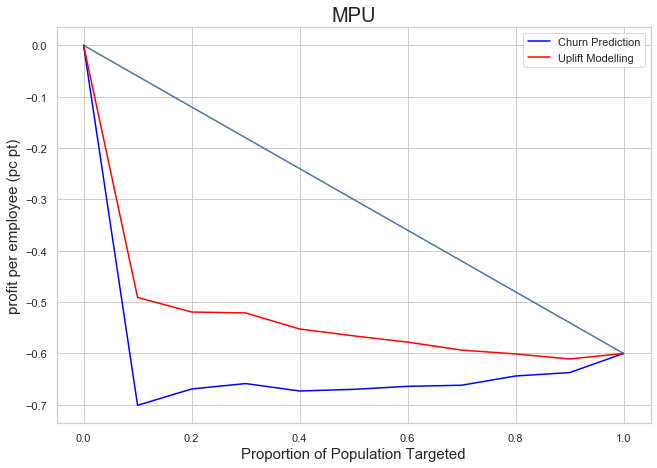

In [68]:
random = np.linspace(CPMPU['Churn Prediction MPU'][0],CPMPU['Churn Prediction MPU'][j],j+1)
sns.lineplot(x=QP.n, y=random)
sns.lineplot(x=CPMPU.n, y=CPMPU['Churn Prediction MPU'], label='Churn Prediction', color='blue')
sns.lineplot(x=CPMPU.n, y=CPMPU['Uplift Prediction MPU'], label='Uplift Modelling', color='red')
# sns.lineplot(x=CPMPU.n, y=CPMPU['Predicted Uplift MPU'], label='Predicted Uplift Modelling', color='green')

sns.set_style("whitegrid")
plt.title('MPU',fontsize=20)
plt.ylabel('profit per employee (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

In [69]:
QP = QP.rename(columns={"uplift": "Predicted Uplift QINI"})
QP['Actual Uplift QINI'] = QU['uplift']
QP['Actual Churn QINI'] = QC['uplift']
QP

,n,Predicted Uplift QINI,Actual Uplift QINI,Actual Churn QINI
0,0.0,0.000000,0.000000,0.000000
1,0.1,40.000000,0.019949,-0.005899
2,0.2,84.000000,0.097215,-0.013291
3,0.3,128.000000,0.101165,-0.020684
4,0.4,173.000000,0.152759,-0.023418
5,0.5,218.000000,0.164532,-0.061139
6,0.6,262.000000,0.145975,-0.046203
7,0.7,307.000000,0.125747,-0.016937
8,0.8,272.000000,0.121519,0.042835
9,0.9,249.727273,0.078962,0.081772


In [70]:
#create new column method = churn_prediction
QC['method'] = 'CP'

#create new column method = uplift_modelling Prediction
QU['method'] = 'Uplift'

#Combine both Churn Prediction and uplift modelling result
result_QINI = pd.concat([QC, QU])
result_QINI = result_QINI.sort_values(by='n')
result_QINI

,n,uplift,method
0,0.0,0.000000,CP
0,0.0,0.000000,Uplift
1,0.1,-0.005899,CP
1,0.1,0.019949,Uplift
2,0.2,-0.013291,CP
2,0.2,0.097215,Uplift
3,0.3,-0.020684,CP
3,0.3,0.101165,Uplift
4,0.4,-0.023418,CP
4,0.4,0.152759,Uplift


In [71]:
#store dataset to be used globally
result_QINI_2 = result_QINI
%store result_QINI_2

Stored 'result_QINI_2' (DataFrame)


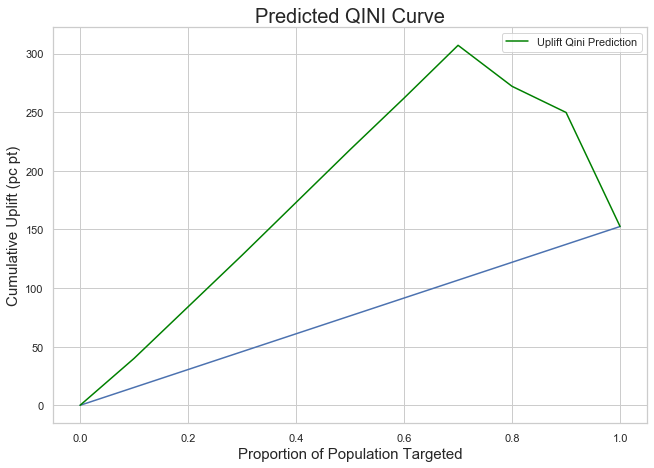

In [72]:
random = np.linspace(QP['Predicted Uplift QINI'][0],QP['Predicted Uplift QINI'][j],j+1)
sns.lineplot(x=QP.n, y=random)
sns.lineplot(x=QP.n, y=QP['Predicted Uplift QINI'], label="Uplift Qini Prediction", color="green")
sns.set_style("whitegrid")
plt.title('Predicted QINI Curve',fontsize=20)
plt.ylabel('Cumulative Uplift (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

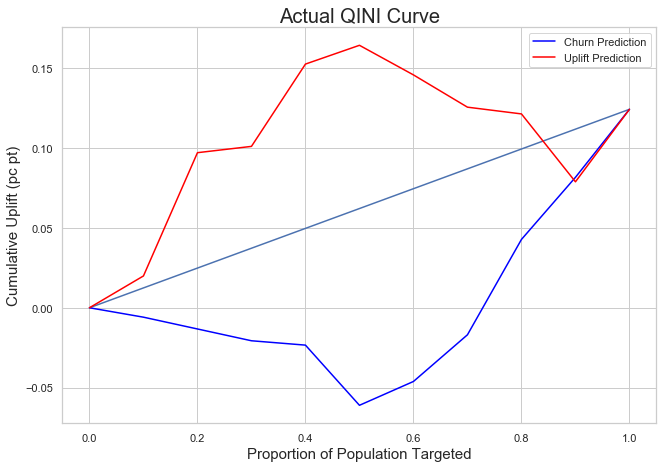

In [73]:
random = np.linspace(QP['Actual Uplift QINI'][0],QP['Actual Uplift QINI'][10],j+1)
ax1 = sns.lineplot(x=QP.n, y=random)
ax2 = sns.lineplot(x=QC.n, y=QC.uplift, label="Churn Prediction", color="blue")
sns.lineplot(x=QU.n, y=QU.uplift, label="Uplift Prediction", color="red")
sns.set_style("whitegrid")
plt.title('Actual QINI Curve',fontsize=20)
plt.ylabel('Cumulative Uplift (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)
# ax1.lines[0].set_linestyle("--")
# ax2.lines[1].set_linestyle("-.")
# df = pd.DataFrame(np.c_[QC.uplift, random]) # modified @Elliots dataframe production
# ax2= sns.lineplot(data=QU.uplift, color = 'red')
# ax = sns.lineplot(data=df, dashes=[(15, 5), (3, 3)])

<h1><i> RESULT

In [74]:
q=220

In [75]:
print("uplift 4 quadrant result")
top1 = df_data_uplift_all[:q]
print("TR = ",sum(top1.target_class == 3))
print("TN = ",sum(top1.target_class == 2))
print("CR = ",sum(top1.target_class == 1))
print("C = ",sum(top1.target_class < 2))

uplift 4 quadrant result
TR =  141
TN =  22
CR =  35
C =  57


In [76]:
# print("uplift traditional result")
# top2 = df_data_Traditional_all[:q]
# print("TR = ",sum(top2.target_class == 3))
# print("TN = ",sum(top2.target_class == 2))
# print("CR = ",sum(top2.target_class == 1))
# print("C = ",sum(top2.target_class < 2))

In [77]:
print("churn result")
top3 = df_data_churn_all[:q]
print("TR = ",sum(top3.target_class == 3))
print("TN = ",sum(top3.target_class == 2))
print("CR = ",sum(top3.target_class == 1))
print("C = ",sum(top3.target_class < 2))

churn result
TR =  142
TN =  11
CR =  63
C =  67


In [78]:
sum((df_data_uplift_all[221:]['Stay'] == 0)&(df_data_uplift_all[221:][treat] == 0))

7

In [79]:
sum((df_data_churn_all[treat]==1)&(df_data_churn_all['Stay']==1))

282

In [80]:
sum((df_data_churn_all[treat]==1))

316

<h2>Pylift

In [81]:
df_data_pylift = df_model.copy()
df_data_pylift = df_data_pylift.drop(['target_class'], axis=1)
df_data_pylift

,Age,Stay,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,NotOvertime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,41,0,2,1102,1,2,2,0,94,3,2,4,5993,19479,8,0,3,1,0,8,0,1,6,4,0,5,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,49,1,1,279,8,1,3,1,61,2,2,2,5130,24907,1,1,4,4,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,37,0,2,1373,2,2,4,1,92,2,1,3,2090,2396,6,0,3,2,0,7,3,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,33,1,1,1392,3,4,4,0,56,3,1,3,2909,23159,1,0,3,3,0,8,3,3,8,7,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,27,1,2,591,2,1,1,1,40,3,1,2,3468,16632,9,1,3,4,1,6,3,3,2,2,2,2,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,1,1,884,23,2,3,1,41,4,2,4,2571,12290,4,1,3,3,1,17,3,3,5,2,0,3,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1466,39,1,2,613,6,1,4,1,42,2,3,1,9991,21457,4,1,3,1,1,9,5,3,7,7,1,7,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1467,27,1,2,155,4,3,2,1,87,4,2,2,6142,5174,1,0,4,2,1,6,0,3,6,2,0,3,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


pylift modelling

In [82]:
up = TransformedOutcome(df_data_pylift, col_treatment=treat, col_outcome='Stay')

In [ ]:
up.randomized_search(n_iter=20, n_jobs=10, random_state=46)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   11.1s


In [ ]:
up.fit(**up.rand_search_.best_params_)

In [ ]:
up.plot(plot_type='cuplift')

In [ ]:
up.test_results_.q1_cgains

In [ ]:
up.plot(plot_type='qini')

In [ ]:
up.shuffle_fit(params=up.rand_search_.best_params_, nthread=30, iterations=5);
up.plot(show_shuffle_fits=True)

In [ ]:
up.plot(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

<h1>Causal Lift

In [ ]:
def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col:str, probability_col:str):
    df.sort_values(by=probability_col, ascending=False, inplace=True)

    subset = df[df[predicted_col] == True]

    rows = []
    for group in np.array_split(subset, 10):
        score = sklearn.metrics.accuracy_score(group[actual_col].tolist(),
                                                   group[predicted_col].tolist(),
                                                   normalize=False)

        rows.append({'NumCases': len(group), 'NumCorrectPredictions': score})

    lift = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    lift['RunningCorrect'] = lift['NumCorrectPredictions'].cumsum()
    lift['PercentCorrect'] = lift.apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x['RunningCorrect'], axis=1)
    lift['CumulativeCorrectBestCase'] = lift['NumCases'].cumsum()
    lift['PercentCorrectBestCase'] = lift['CumulativeCorrectBestCase'].apply(
        lambda x: 100 if (100 / lift['NumCorrectPredictions'].sum()) * x > 100 else (100 / lift[
            'NumCorrectPredictions'].sum()) * x)
    lift['AvgCase'] = lift['NumCorrectPredictions'].sum() / len(lift)
    lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
    lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x)

    #Lift Chart
    lift['NormalisedPercentAvg'] = 1
    lift['NormalisedPercentWithModel'] = lift['PercentCorrect'] / lift['PercentAvgCase']

    return lift

In [ ]:
cum_lift = calc_cumulative_gains(df_data_churn_all, 'Stay', 'p_stay', 'stay_score')
cum_lift

In [ ]:
#splitting train and test groups
train_df, test_df = train_test_split(df_model_causal, test_size=0.2, random_state=42, stratify=df_model_causal['Treatment'])

In [ ]:
""" Step 0. Import CausalLift
"""

from causallift import CausalLift

""" Step 1. Feed datasets and optionally compute estimated propensity scores
using logistic regression if set enable_ipw = True.
"""


cl = CausalLift(train_df, test_df, enable_ipw=True, verbose=3)

""" Step 2. Train 2 classification models (XGBoost) for treated and untreated
samples independently and compute estimated CATE (Conditional Average Treatment
Effect), ITE (Individual Treatment Effect), or uplift score.
"""

train_df, test_df = cl.estimate_cate_by_2_models()

""" Step 3. Estimate how much conversion rate will increase by selecting treatment
(campaign) targets as recommended by the uplift modeling.
"""

estimated_effect_df = cl.estimate_recommendation_impact()

In [ ]:
estimated_effect_df